In [2]:
from dottamine import dotim
import numpy as np
import skimage as sk
import cv2
from scipy.ndimage import distance_transform_edt, convolve, label
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from skimage.feature import peak_local_max
from copy import copy
from skimage.segmentation import watershed
from collections import deque
from skimage.filters import sobel

In [2]:
image = sk.io.imread('./../ppujol/DomesN2V/62_denoised.tif')
image = np.transpose(image[3], axes=(1, 0, 2))
image = np.transpose(image, axes=(2, 1, 0))

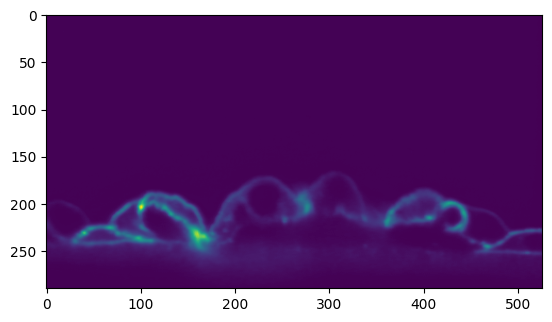

In [3]:
plt.imshow(image[330])

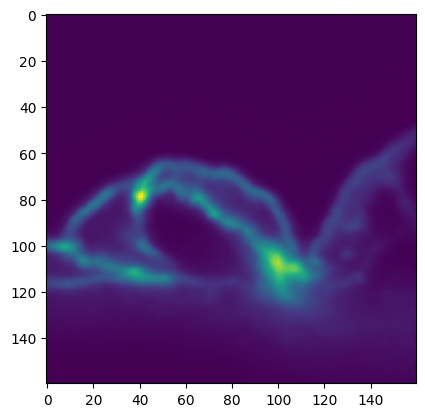

In [16]:
z, y, x = 330, 205, 140
# cell = image[180:300, 300:, 250:350]
# cell = image[270:300, 320:350, 390:420]
cell = image[z-80:z+80, y-80:y+80, x-80:x+80]

# cell = image[260:340]
plt.imshow(cell[80])

In [17]:
def normalize_image(im, mult_factor = 1):
    norm_im = (im - im.min()) / (im.max()-im.min()) * mult_factor
    return norm_im
def reverse_values(im):
    rev_im = im.max()-im
    return rev_im

def clahe(image):
    flat_image = image.flatten()
    clahe = cv2.createCLAHE(clipLimit=1, tileGridSize=(2,2))
    cl1 = clahe.apply(normalize_image(flat_image, 255).astype(np.uint8))
    clahe_image = cl1.reshape(image.shape)

    return clahe_image

In [18]:
import numpy as np
from scipy.ndimage import median_filter

def calculate_median(array):
    """Return the median of 1-d array"""
    sorted_array = np.sort(array)
    median = sorted_array[len(array)//2]
    return median

def level_A(z_min, z_med, z_max, z_xy, S_xy, S_max):
    if(z_min < z_med < z_max):
        return level_B(z_min, z_med, z_max, z_xy, S_xy, S_max)
    else:
        S_xy += 2  # Increase the size of S_xy to the next odd value.
        if S_xy <= S_max:  # Repeat process
            return level_A(z_min, z_med, z_max, z_xy, S_xy, S_max)
        else:
            return z_med

def level_B(z_min, z_med, z_max, z_xy, S_xy, S_max):
    if(z_min < z_xy < z_max):
        return z_xy
    else:
        return z_med

def amf_3d(image, initial_window, max_window):
    """Runs the Adaptive Median Filter process on a 3D image"""
    xlength, ylength, zlength = image.shape  # Get the shape of the image.

    S_max = max_window
    S_xy = initial_window  # Dynamically grow

    output_image = image.copy()

    for depth in range(S_xy, zlength-S_xy-1):
        for row in range(S_xy, xlength-S_xy-1):
            for col in range(S_xy, ylength-S_xy-1):
                filter_window = image[row - S_xy: row + S_xy + 1,
                                      col - S_xy: col + S_xy + 1,
                                      depth - S_xy: depth + S_xy + 1]  # Filter window
                target = filter_window.reshape(-1)  # Make 1-dimensional
                z_min = np.min(target)  # Min of intensity values
                z_max = np.max(target)  # Max of intensity values
                z_med = calculate_median(target)  # Median of intensity values
                z_xy = image[row, col, depth]  # Current intensity

                # Level A & B
                new_intensity = level_A(z_min, z_med, z_max, z_xy, S_xy, S_max)
                output_image[row, col, depth] = new_intensity

    return output_image

In [505]:
# import tifffile as tiff
# tiff.imwrite('./../ppujol/good_single_cell.tif', normalize_image(cell, 255).astype(np.uint16), imagej=True)

In [15]:
# cell = sk.io.imread('./../ppujol/good_single_cell.tif')

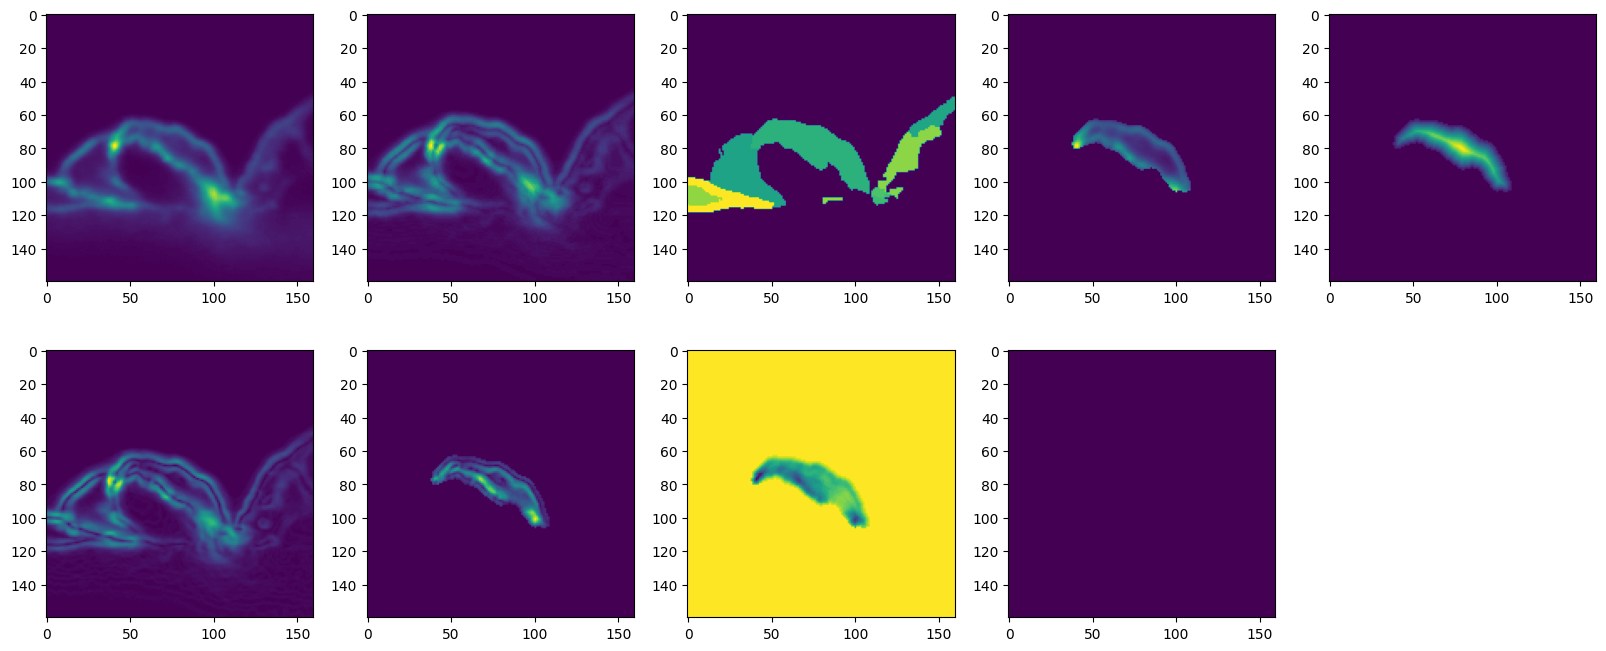

In [19]:
from skimage.morphology import disk, ball
from skimage.segmentation import watershed
from skimage import data
from skimage.filters import rank
from skimage.util import img_as_ubyte
from scipy import ndimage as ndi

y = 80


# image = normalize_image(image, 255).astype(np.uint16)
cell = normalize_image(cell, 255).astype(np.uint8)

# cell_border = clahe(cell)
cell_border = cell
# denoised = amf_3d(cell_border, 3, 11)

denoised = rank.median(cell_border, ball(2)) # It was 2

markers = rank.gradient(denoised, ball(5)) < 10
markers = ndi.label(markers)[0]

gradient = rank.gradient(denoised, ball(2))
labels = watershed(gradient, markers)

plt.figure(figsize=(20,8))
plt.subplot(251)
plt.imshow(cell_border[y])
plt.subplot(252)
plt.imshow(gradient[y])    
plt.subplot(253)
plt.imshow(labels[y])

seed_point = (80,80,80)

labels[labels != labels[seed_point]] = 0

labels = sk.morphology.binary_closing(labels, footprint=sk.morphology.ball(5))
labels = sk.morphology.binary_opening(labels, footprint=sk.morphology.ball(2))


maskImage = labels*cell_border
plt.subplot(254)
plt.imshow(maskImage[y])


edt = ndi.distance_transform_edt(maskImage)
plt.subplot(255)
plt.imshow(edt[y])

edge_scharr = sk.filters.scharr(cell_border)
plt.subplot(256)
plt.imshow(edge_scharr[y])
edge_scharr_cell = edge_scharr*edt
# ndi.distance_transform_edt(maskImage)

plt.subplot(257)
plt.imshow(edge_scharr_cell[y])

edt_border = reverse_values(edt*cell_border)
plt.subplot(258)
plt.imshow(edt_border[y])


mask = np.zeros(edt.shape, dtype=bool)
markers, _ = ndi.label(mask)
lab = watershed(-edt, markers, mask=labels)

plt.subplot(259)
plt.imshow(lab[y])


[[67 74 77]]


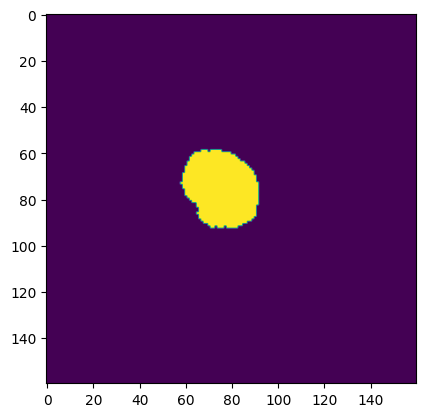

In [17]:
mask = np.zeros(edt.shape, dtype=bool)
markers, _ = ndi.label(mask)
coords = peak_local_max(edt, footprint=np.ones((100,100,100)), labels=labels)
print(coords)
mask[tuple(coords.T)] = True
lab = watershed(-edt, markers, mask=labels)
plt.imshow(labels[60])

In [14]:
import tifffile as tiff
tiff.imwrite('./../ppujol/tempDomes/62_3_330_205_140_cell_2.tif', normalize_image(reverse_values(edt_border), 255).astype(np.uint16), imagej=True)
tiff.imwrite('./../ppujol/tempDomes/62_3_330_205_140_original.tif', normalize_image(cell, 255).astype(np.uint16), imagej=True)

In [3]:
cell_3D = sk.io.imread('./../ppujol/tempDomes/62_3_330_205_140_cell.tif')
cell_3D[cell_3D > 0] = 1

from dw3d import geometry_reconstruction_3d

DW = geometry_reconstruction_3d(cell_3D, min_dist=1, expansion_labels=0, mode='skimage')
DW.plot_cells_polyscope()
# v = DW.plot_in_napari(add_mesh=True)

## Use the mesh to analyze the geometry:
Mesh=DW.return_dcel()
Mesh.compute_curvatures_interfaces()
Mesh.compute_areas_interfaces()
Mesh.compute_volumes_cells()
Mesh.compute_length_trijunctions()

Mesh.compute_angles_junctions()

[polyscope] Backend: openGL3_glfw -- Loaded openGL version: 4.6 (Core Profile) Mesa 23.0.4-0ubuntu1~22.04.1


{}